--- Loading results for: parm ---
--- Loading results for: tcheby ---
--- Loading results for: stch ---

Graph saved to pareto_comparison.png


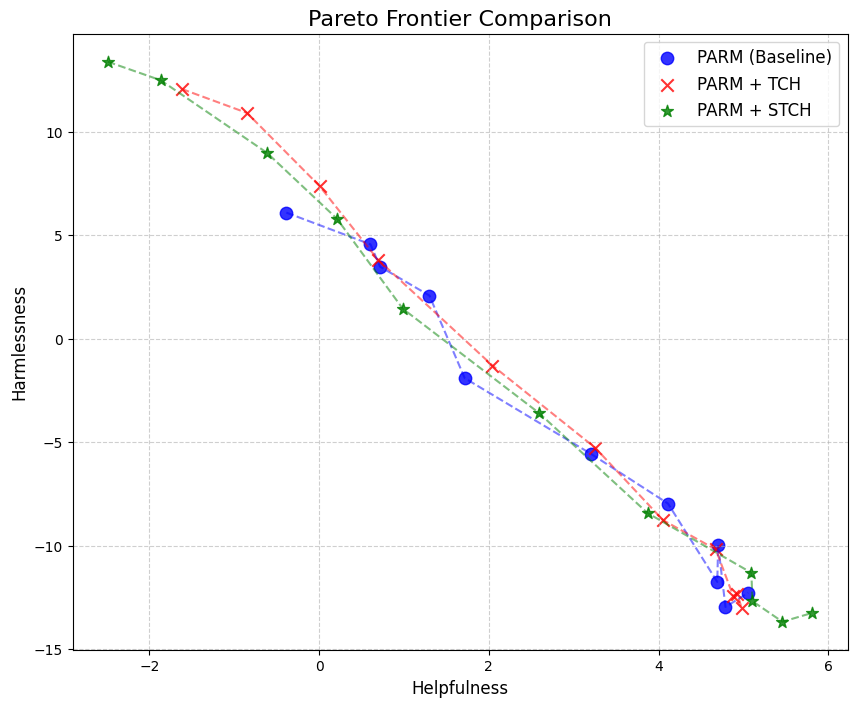

In [ ]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np


BASE_DIR = "/home/sjkim/parm/code/evaluation/results"
ALGORITHMS = {
    "parm": {"label": "PARM (Baseline)", "color": "blue", "marker": "o"},
    "tcheby": {"label": "PARM + TCH", "color": "red", "marker": "x"},
    "stch": {"label": "PARM + STCH", "color": "green", "marker": "*"},
}

preferences = [
    (0.0, 1.0, 0.0),
    (0.1, 0.9, 0.0),
    (0.2, 0.8, 0.0),
    (0.3, 0.7, 0.0),
    (0.4, 0.6, 0.0),
    (0.5, 0.5, 0.0),
    (0.6, 0.4, 0.0),
    (0.7, 0.3, 0.0),
    (0.8, 0.2, 0.0),
    (0.9, 0.1, 0.0),
    (1.0, 0.0, 0.0)
]

def load_rewards(algo_name):
    """
    특정 알고리즘 폴더에서 모든 Preference에 대한 Reward 값을 읽어옵니다.
    """
    rewards_help = []
    rewards_harm = []
    valid_prefs = [] 

    print(f"--- Loading results for: {algo_name} ---")
    
    for alpha_help, alpha_harm in preferences:
        dir_name = f"PARM_{alpha_help}help_{alpha_harm}harm"
        file_path = os.path.join(BASE_DIR, algo_name, dir_name, "mean_result.json")
        
        if os.path.exists(file_path):
            try:
                with open(file_path, 'r') as f:
                    data = json.load(f)
                    # JSON 키에 맞춰 데이터 추출
                    r_help = data.get("help", None)
                    r_harm = -data.get("harm", None)
                    
                    if r_help is not None and r_harm is not None:
                        rewards_help.append(r_help)
                        rewards_harm.append(r_harm)
                        valid_prefs.append((alpha_help, alpha_harm))
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
        else:
            print(f"Warning: File not found: {file_path}")

    return rewards_help, rewards_harm, valid_prefs

#visualization
plt.figure(figsize=(10, 8))

for algo, style in ALGORITHMS.items():
    # 데이터 로드
    x_help, y_harm, prefs = load_rewards(algo)
    
    if not x_help:
        print(f"Skipping {algo}: No data found.")
        continue

    plt.scatter(x_help, y_harm, 
                label=style["label"], 
                color=style["color"], 
                marker=style["marker"], 
                s=80, alpha=0.8)
    
    points = sorted(zip(x_help, y_harm), key=lambda pair: pair[0]) # sort by helpfulness
    sorted_x = [p[0] for p in points]
    sorted_y = [p[1] for p in points]
    plt.plot(sorted_x, sorted_y, color=style["color"], linestyle='--', alpha=0.5)

    # ass preferences    
    '''for (hx, hy), (w_help, w_harm) in zip(points, prefs):
        # ah는 helpfulness alpha 값
        plt.annotate(f"{w_help, w_harm}", (hx, hy), fontsize=8, xytext=(5, 5), textcoords='offset points')'''

plt.title("Pareto Frontier Comparison", fontsize=16)
plt.xlabel("Helpfulness", fontsize=12)
plt.ylabel("Harmlessness", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

output_img = "pareto_comparison.png"
plt.savefig(output_img, dpi=300, bbox_inches='tight')
print(f"\nGraph saved to {output_img}")
plt.show()

In [ ]:
import os
import json
import numpy as np

BASE_DIR = "/home/sjkim/parm/code/evaluation/results"
ALGORITHMS = {
    "parm": {"label": "PARM (Baseline)"},
    "tcheby": {"label": "PARM + tch"},
    "stch": {"label": "PARM + stch"},
}

preferences = [
    (0.0, 1.0), (0.1, 0.9), (0.2, 0.8), (0.3, 0.7), (0.4, 0.6),
    (0.5, 0.5), (0.6, 0.4), (0.7, 0.3), (0.8, 0.2), (0.9, 0.1), (1.0, 0.0)
]

def load_rewards(algo_name):
    rewards_help = []
    rewards_harm = []
    
    print(f"Loading data for: {algo_name}...")
    
    for alpha_help, alpha_harm, alpha_humor in preferences:
        dir_name = f"PARM_{alpha_help}help_{alpha_harm}harm"
        file_path = os.path.join(BASE_DIR, algo_name, dir_name, "mean_result.json")
        
        if os.path.exists(file_path):
            try:
                with open(file_path, 'r') as f:
                    data = json.load(f)
                    r_help = data.get("help", None)
                    r_harm = -data.get("harm", None) # note that safe rlhf's cost model derives the harmfulness
                    
                    if r_help is not None and r_harm is not None:
                        rewards_help.append(r_help)
                        rewards_harm.append(r_harm)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
    
    return rewards_help, rewards_harm

def calculate_hypervolume(points, ref_point):
    
    sorted_points = sorted(points, key=lambda p: p[0], reverse=True)
    
    ref_x, ref_y = ref_point
    hv = 0.0
    current_max_y = ref_y
    
    for x, y in sorted_points:
        if y > current_max_y:
            width = x - ref_x
            height = y - current_max_y
            hv += width * height
            current_max_y = y
            
    return hv

def calculate_mip(rewards_help, rewards_harm):
    """
    MIP (Mean Inner Product)를 계산합니다.
    각 preference 조합별로 (가중치 * 점수)의 내적을 구한 뒤 평균을 냅니다.
    """
    if not rewards_help or len(rewards_help) != len(preferences):
        return 0.0
        
    ip_list = []
    for i, (alpha_help, alpha_harm) in enumerate(preferences):
        r_help = rewards_help[i]
        r_harm = rewards_harm[i]
    
        ip = (alpha_help * r_help) + (alpha_harm * r_harm)
        ip_list.append(ip)
        
    return np.mean(ip_list)

def main():
    all_data = {}

    global_min_help = float('inf')
    global_min_harm = float('inf')
    
    for algo in ALGORITHMS.keys():
        rh, rm = load_rewards(algo)
        if rh:

            points = list(zip(rh, rm))
            
            all_data[algo] = {
                'points': points,
                'rh': rh,
                'rm': rm
            }

            min_h = min(rh)
            min_m = min(rm)
            if min_h < global_min_help: global_min_help = min_h
            if min_m < global_min_harm: global_min_harm = min_m
        else:
            print(f"Warning: No data found for {algo}")

    if global_min_help == float('inf'):
        print("No valid data loaded.")
        return

    padding = 1.0 
    ref_point = (global_min_help - padding, global_min_harm - padding)
    
    print(f"\n[Reference Point]: {ref_point} (Global Min - {padding})")
    print("-" * 87)
    print(f"{'Algorithm':<20} | {'Hypervolume':<15} | {'HV Improvement':<15} | {'MIP':<10} | {'MIP Improvement':<15}")
    print("-" * 87)

    baseline_hv = 0.0
    baseline_mip = 0.0
    if "parm" in all_data:
        baseline_hv = calculate_hypervolume(all_data["parm"]['points'], ref_point)
        baseline_mip = calculate_mip(all_data["parm"]['rh'], all_data["parm"]['rm'])

    for algo_key in ALGORITHMS.keys():
        if algo_key not in all_data:
            continue
            
        data = all_data[algo_key]
        points = data['points']
        rh = data['rh']
        rm = data['rm']

        hv = calculate_hypervolume(points, ref_point)
        mip = calculate_mip(rh, rm)

        hv_imp_str = "-"
        mip_imp_str = "-"
        if baseline_hv > 0 and baseline_mip > 0 and algo_key != "parm":
            hv_ratio = ((hv - baseline_hv) / baseline_hv) * 100
            mip_ratio = ((mip - baseline_mip) / baseline_mip) * 100
            hv_imp_str = f"{hv_ratio:+.2f}%"
            mip_imp_str = f"{mip_ratio:+.2f}%"
        elif algo_key == "parm":
            hv_imp_str = "(Baseline)"
            mip_imp_str = "(Baseline)"
            
        
        label = ALGORITHMS[algo_key]['label']
        print(f"{label:<20} | {hv:<15.4f} | {hv_imp_str:<15} | {mip:<10.4f} | {mip_imp_str:<15}")

    print("-" * 87)

if __name__ == "__main__":
    main()

Loading data for: parm...
Loading data for: tcheby...
Loading data for: stch...

[Reference Point]: (-3.490177001953125, -14.669677734375) (Global Min - 1.0)
---------------------------------------------------------------------------------------
Algorithm            | Hypervolume     | HV Improvement  | MIP        | MIP Improvement
---------------------------------------------------------------------------------------
PARM (Baseline)      | 123.8901        | (Baseline)      | 2.0459     | (Baseline)     
PARM + tch           | 138.9121        | +12.13%         | 3.4889     | +70.53%        
PARM + stch          | 134.9301        | +8.91%          | 4.2215     | +106.34%       
---------------------------------------------------------------------------------------


--- Loading results for: parm ---


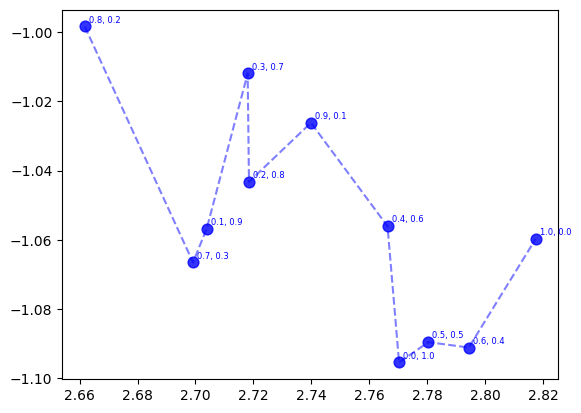

--- Loading results for: parm ---


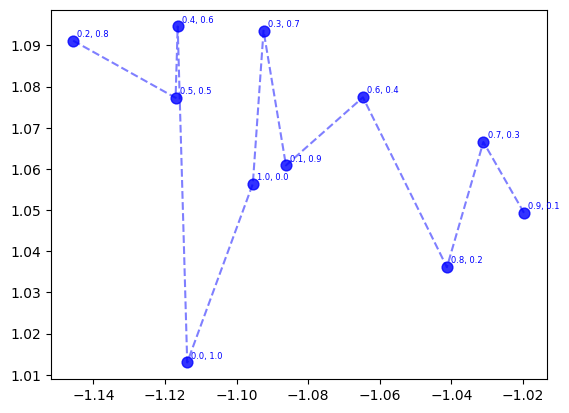

--- Loading results for: parm ---


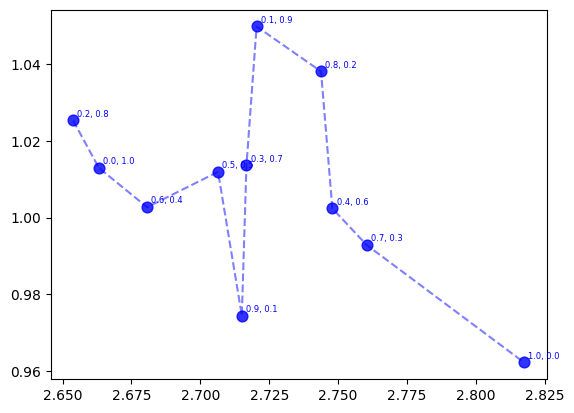

--- Loading results for: tch ---


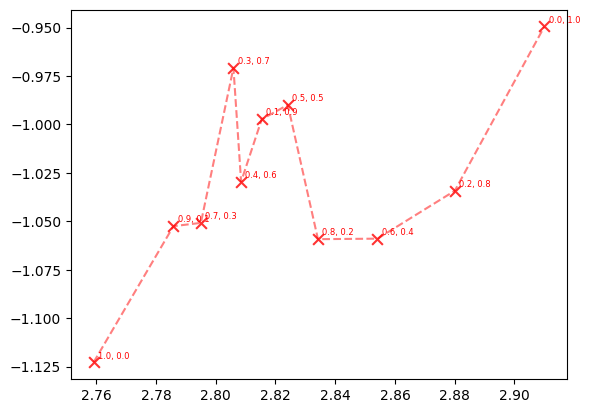

--- Loading results for: tch ---


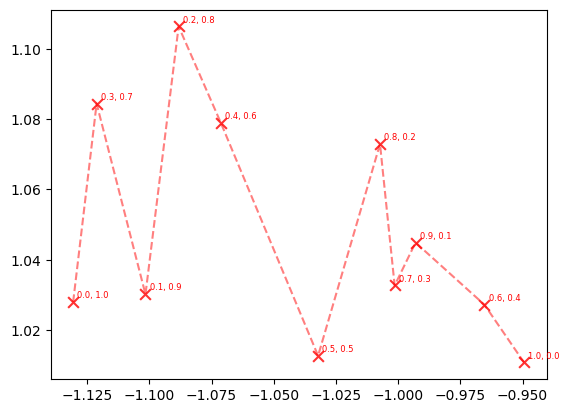

--- Loading results for: tch ---


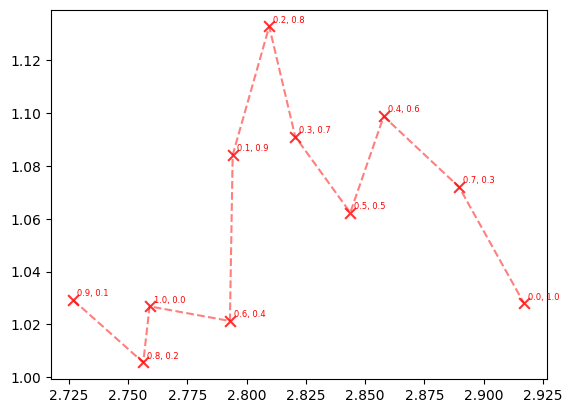

--- Loading results for: stch ---


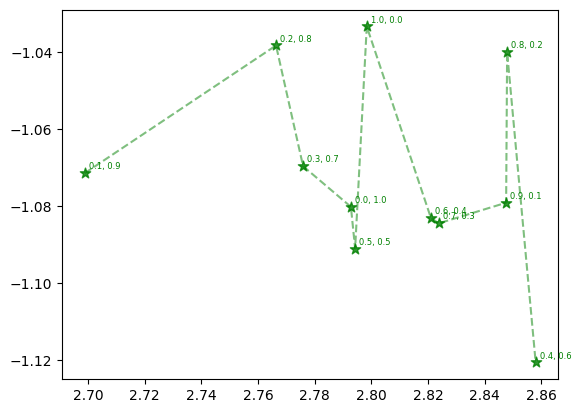

--- Loading results for: stch ---


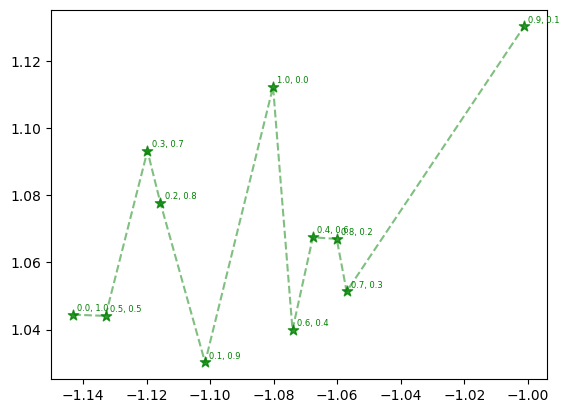

--- Loading results for: stch ---


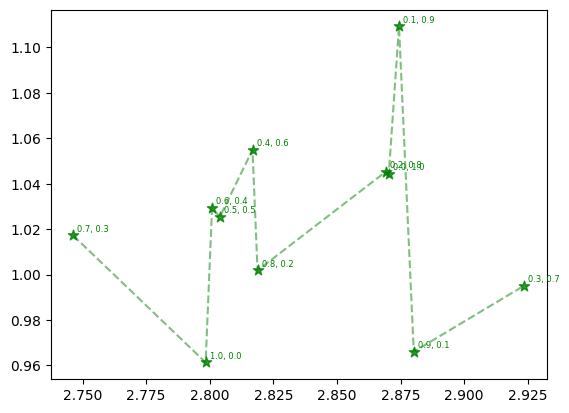

In [ ]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np

BASE_DIR = "/home/sjkim/parm/code/evaluation/results/hh"
ALGORITHMS = {
    "parm": {"label": "PARM (Baseline)", "color": "blue", "marker": "o"},
    "tch": {"label": "PARM + TCH", "color": "red", "marker": "x"},
    "stch": {"label": "PARM + STCH", "color": "green", "marker": "*"},
}

preferences = dict()
preferences[('help', 'harm')] = [
    (0.0, 1.0, 0.0), 
    (0.1, 0.9, 0.0), 
    (0.2, 0.8, 0.0), 
    (0.3, 0.7, 0.0),
    (0.4, 0.6, 0.0), 
    (0.5, 0.5, 0.0), 
    (0.6, 0.4, 0.0), 
    (0.7, 0.3, 0.0),
    (0.8, 0.2, 0.0), 
    (0.9, 0.1, 0.0), 
    (1.0, 0.0, 0.0)
]
preferences[('harm', 'humor')] = [
    (0.0, 0.0, 1.0), 
    (0.0, 0.1, 0.9), 
    (0.0, 0.2, 0.8), 
    (0.0, 0.3, 0.7),
    (0.0, 0.4, 0.6), 
    (0.0, 0.5, 0.5), 
    (0.0, 0.6, 0.4), 
    (0.0, 0.7, 0.3),
    (0.0, 0.8, 0.2), 
    (0.0, 0.9, 0.1),
    (0.0, 1.0, 0.0)
]
preferences[('help', 'humor')] = [
    (0.0, 0.0, 1.0),
    (0.1, 0.0, 0.9), 
    (0.2, 0.0, 0.8), 
    (0.3, 0.0, 0.7),
    (0.4, 0.0, 0.6), 
    (0.5, 0.0, 0.5), 
    (0.6, 0.0, 0.4), 
    (0.7, 0.0, 0.3),
    (0.8, 0.0, 0.2), 
    (0.9, 0.0, 0.1),
    (1.0, 0.0, 0.0)
]

def load_all_metrics(algo_name, obj_key):

    rewards = {"help": [], "harm": [], "humor": []}
    valid_prefs = []

    print(f"--- Loading results for: {algo_name} ---")
    
    for alpha_help, alpha_harm, alpha_humor in preferences[obj_key]:
        dir_name = f"PARM_{alpha_help}help_{alpha_harm}harm_{alpha_humor}humor"
        file_path = os.path.join(BASE_DIR, algo_name, dir_name, "mean_result.json")
        
        if os.path.exists(file_path):
            try:
                with open(file_path, 'r') as f:
                    data = json.load(f)
                    r_help = data.get("help")
                    r_harm = data.get("harm")
                    r_humor = data.get("humor")
                    
                    if all(v is not None for v in [r_help, r_harm, r_humor]):
                        rewards["help"].append(r_help)
                        rewards["harm"].append(r_harm)
                        rewards["humor"].append(r_humor)
                        valid_prefs.append((alpha_help, alpha_harm, alpha_humor))
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
        else:
            # print(f"Warning: File not found: {file_path}")
            pass

    return rewards, valid_prefs

plot_configs = [
    ("help", "harm", "Helpfulness vs Harmlessness"),
    ("help", "humor", "Helpfulness vs Humor"),
    ("harm", "humor", "Harmlessness vs Humor")
]

for algo, style in ALGORITHMS.items():
    for obj_key in [('help', 'harm'), ('harm', 'humor'), ('help','humor')]:
        data, prefs = load_all_metrics(algo, obj_key)
        
        if not data["help"]:
            print(f"Skipping {algo}: No data found.")
            continue

        x_key = obj_key[0]
        y_key = obj_key[1]
        x_vals = data[x_key]
        y_vals = data[y_key]

        plt.scatter(x_vals, y_vals, 
                label=style["label"], 
                color=style["color"], 
                marker=style["marker"], 
                s=60, alpha=0.8)
        
        sorted_points = sorted(zip(x_vals, y_vals), key=lambda k: k[0])
        sorted_x = [p[0] for p in sorted_points]
        sorted_y = [p[1] for p in sorted_points]
        plt.plot(sorted_x, sorted_y, color=style["color"], linestyle='--', alpha=0.5)
        
        for x, y, (w_help, w_harm, w_humor) in zip(x_vals, y_vals, prefs):
            if x_key == "help" and y_key == "harm":
                label_text = f"{w_help}, {w_harm}"
            elif x_key == "help" and y_key == "humor":
                label_text = f"{w_help}, {w_humor}"
            elif x_key == "harm" and y_key == "humor":
                label_text = f"{w_harm}, {w_humor}"
            plt.annotate(label_text, (x, y), textcoords="offset points", xytext=(3, 3), fontsize=6, color=style["color"])
        plt.show()

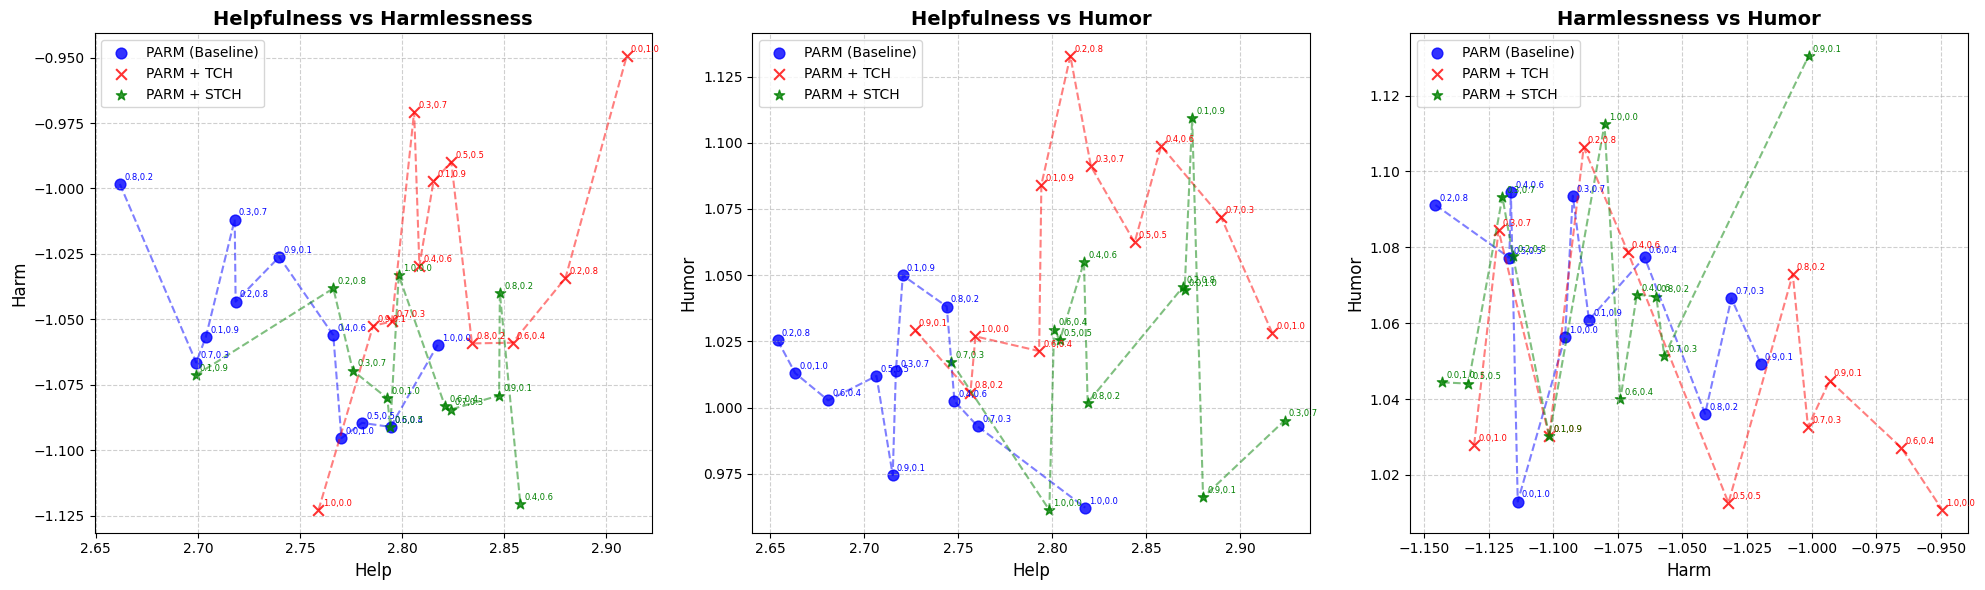

In [ ]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np

BASE_DIR = "/home/sjkim/parm/code/evaluation/results/hh"
ALGORITHMS = {
    "parm": {"label": "PARM (Baseline)", "color": "blue", "marker": "o"},
    "tch": {"label": "PARM + TCH", "color": "red", "marker": "x"},
    "stch": {"label": "PARM + STCH", "color": "green", "marker": "*"},
}

preferences = dict()
preferences[('help', 'harm')] = [
    (0.0, 1.0, 0.0), (0.1, 0.9, 0.0), (0.2, 0.8, 0.0), (0.3, 0.7, 0.0),
    (0.4, 0.6, 0.0), (0.5, 0.5, 0.0), (0.6, 0.4, 0.0), (0.7, 0.3, 0.0),
    (0.8, 0.2, 0.0), (0.9, 0.1, 0.0), (1.0, 0.0, 0.0)
]
preferences[('harm', 'humor')] = [
    (0.0, 0.0, 1.0), (0.0, 0.1, 0.9), (0.0, 0.2, 0.8), (0.0, 0.3, 0.7),
    (0.0, 0.4, 0.6), (0.0, 0.5, 0.5), (0.0, 0.6, 0.4), (0.0, 0.7, 0.3),
    (0.0, 0.8, 0.2), (0.0, 0.9, 0.1), (0.0, 1.0, 0.0)
]
preferences[('help', 'humor')] = [
    (0.0, 0.0, 1.0), (0.1, 0.0, 0.9), (0.2, 0.0, 0.8), (0.3, 0.0, 0.7),
    (0.4, 0.0, 0.6), (0.5, 0.0, 0.5), (0.6, 0.0, 0.4), (0.7, 0.0, 0.3),
    (0.8, 0.0, 0.2), (0.9, 0.0, 0.1), (1.0, 0.0, 0.0)
]

def load_all_metrics(algo_name, obj_key):
    rewards = {"help": [], "harm": [], "humor": []}
    valid_prefs = []
    
    for alpha_help, alpha_harm, alpha_humor in preferences[obj_key]:
        dir_name = f"PARM_{alpha_help}help_{alpha_harm}harm_{alpha_humor}humor"
        file_path = os.path.join(BASE_DIR, algo_name, dir_name, "mean_result.json")
        
        if os.path.exists(file_path):
            try:
                with open(file_path, 'r') as f:
                    data = json.load(f)
                    r_help = data.get("help")
                    r_harm = data.get("harm")
                    r_humor = data.get("humor")
                    
                    if all(v is not None for v in [r_help, r_harm, r_humor]):
                        rewards["help"].append(r_help)
                        rewards["harm"].append(r_harm)
                        rewards["humor"].append(r_humor)
                        valid_prefs.append((alpha_help, alpha_harm, alpha_humor))
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
    return rewards, valid_prefs

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

target_plots = [
    (('help', 'harm'), "Helpfulness vs Harmlessness"),
    (('help', 'humor'), "Helpfulness vs Humor"),
    (('harm', 'humor'), "Harmlessness vs Humor")
]

for algo, style in ALGORITHMS.items():

    for idx, (obj_key, title) in enumerate(target_plots):
        ax = axes[idx]
        
        data, prefs = load_all_metrics(algo, obj_key)
        
        if not data["help"]:
            print(f"Skipping {algo} for {obj_key}: No data found.")
            continue

        x_key = obj_key[0]
        y_key = obj_key[1]
        x_vals = data[x_key]
        y_vals = data[y_key]

        ax.scatter(x_vals, y_vals, 
                label=style["label"], 
                color=style["color"], 
                marker=style["marker"], 
                s=60, alpha=0.8)
        
        sorted_points = sorted(zip(x_vals, y_vals), key=lambda k: k[0])
        sorted_x = [p[0] for p in sorted_points]
        sorted_y = [p[1] for p in sorted_points]
        ax.plot(sorted_x, sorted_y, color=style["color"], linestyle='--', alpha=0.5)

        for x, y, (w_help, w_harm, w_humor) in zip(x_vals, y_vals, prefs):
            if x_key == "help" and y_key == "harm":
                label_text = f"{w_help},{w_harm}"
            elif x_key == "help" and y_key == "humor":
                label_text = f"{w_help},{w_humor}"
            elif x_key == "harm" and y_key == "humor":
                label_text = f"{w_harm},{w_humor}"
            else:
                label_text = ""
            
            ax.annotate(label_text, (x, y), textcoords="offset points", xytext=(3, 3), 
                        fontsize=6, color=style["color"])

for idx, (obj_key, title) in enumerate(target_plots):
    ax = axes[idx]
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(obj_key[0].capitalize(), fontsize=12)
    ax.set_ylabel(obj_key[1].capitalize(), fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(loc='best')  

plt.tight_layout()
plt.show() 

In [ ]:
import os
import json
import numpy as np

BASE_DIR = "/home/sjkim/parm/code/evaluation/results/hh"
ALGORITHMS = {
    "parm": {"label": "PARM (Baseline)"},
    "tch":  {"label": "PARM + TCH"},
    "stch": {"label": "PARM + STCH"},
}

preferences = dict()
preferences[('help', 'harm')] = [
    (0.0, 1.0, 0.0), (0.1, 0.9, 0.0), (0.2, 0.8, 0.0), (0.3, 0.7, 0.0),
    (0.4, 0.6, 0.0), (0.5, 0.5, 0.0), (0.6, 0.4, 0.0), (0.7, 0.3, 0.0),
    (0.8, 0.2, 0.0), (0.9, 0.1, 0.0), (1.0, 0.0, 0.0)
]
preferences[('harm', 'humor')] = [
    (0.0, 0.0, 1.0), (0.0, 0.1, 0.9), (0.0, 0.2, 0.8), (0.0, 0.3, 0.7),
    (0.0, 0.4, 0.6), (0.0, 0.5, 0.5), (0.0, 0.6, 0.4), (0.0, 0.7, 0.3),
    (0.0, 0.8, 0.2), (0.0, 0.9, 0.1), (0.0, 1.0, 0.0)
]
preferences[('help', 'humor')] = [
    (0.0, 0.0, 1.0), (0.1, 0.0, 0.9), (0.2, 0.0, 0.8), (0.3, 0.0, 0.7),
    (0.4, 0.0, 0.6), (0.5, 0.0, 0.5), (0.6, 0.0, 0.4), (0.7, 0.0, 0.3),
    (0.8, 0.0, 0.2), (0.9, 0.0, 0.1), (1.0, 0.0, 0.0)
]

def load_data_for_pair(algo_name, obj_key):

    x_name, y_name = obj_key
    x_scores = []
    y_scores = []
    used_prefs = [] 
    
    for w_h, w_m, w_u in preferences[obj_key]:
        dir_name = f"PARM_{w_h}help_{w_m}harm_{w_u}humor"
        file_path = os.path.join(BASE_DIR, algo_name, dir_name, "mean_result.json")
        
        if os.path.exists(file_path):
            try:
                with open(file_path, 'r') as f:
                    data = json.load(f)
                    val_x = data.get(x_name)
                    val_y = data.get(y_name)
                    
                    if val_x is not None and val_y is not None:
                        x_scores.append(val_x)
                        y_scores.append(val_y)
                        used_prefs.append((w_h, w_m, w_u))
            except Exception:
                pass
                
    return x_scores, y_scores, used_prefs

def calculate_hypervolume(points, ref_point):

    sorted_points = sorted(points, key=lambda p: p[0], reverse=True)
    ref_x, ref_y = ref_point
    hv = 0.0
    current_max_y = ref_y
    
    for x, y in sorted_points:
        if x < ref_x or y < ref_y:
            continue
            
        if y > current_max_y:
            width = x - ref_x
            height = y - current_max_y
            hv += width * height
            current_max_y = y
    return hv

def calculate_mip(x_scores, y_scores, used_prefs, obj_key):
    if not x_scores:
        return 0.0
        
    x_name, y_name = obj_key
    ip_list = []
    
    for i in range(len(x_scores)):
        score_x = x_scores[i]
        score_y = y_scores[i]
        
        wh, wm, wu = used_prefs[i]

        weight_x = 0.0
        weight_y = 0.0
        
        if x_name == 'help': weight_x = wh
        elif x_name == 'harm': weight_x = wm
        elif x_name == 'humor': weight_x = wu
            
        if y_name == 'help': weight_y = wh
        elif y_name == 'harm': weight_y = wm
        elif y_name == 'humor': weight_y = wu

        ip = (weight_x * score_x) + (weight_y * score_y)
        ip_list.append(ip)
        
    return np.mean(ip_list)

def main():

    scenarios = [
        (('help', 'harm'), "Helpfulness vs Harmlessness"),
        (('help', 'humor'), "Helpfulness vs Humor"),
        (('harm', 'humor'), "Harmlessness vs Humor")
    ]
    
    for obj_key, title in scenarios:
        print("\n" + "=" * 95)
        print(f"  Comparison Scenario: {title} ({obj_key[0]} vs {obj_key[1]})")
        print("=" * 95)

        scenario_data = {}
        global_min_x = float('inf')
        global_min_y = float('inf')
        
        for algo in ALGORITHMS.keys():
            xs, ys, prefs = load_data_for_pair(algo, obj_key)
            if xs:
                points = list(zip(xs, ys))
                scenario_data[algo] = {
                    'xs': xs, 'ys': ys, 'points': points, 'prefs': prefs
                }
                
                min_x = min(xs)
                min_y = min(ys)
                if min_x < global_min_x: global_min_x = min_x
                if min_y < global_min_y: global_min_y = min_y
        
        if global_min_x == float('inf'):
            print("  No data found for this scenario.")
            continue
 
        PADDING = 0.1
        ref_point = (global_min_x - PADDING, global_min_y - PADDING)
        print(f"  [Ref Point]: ({ref_point[0]:.4f}, {ref_point[1]:.4f}) <- (Min - {PADDING})")

        base_hv = 0.0
        base_mip = 0.0
        if "parm" in scenario_data:
            d = scenario_data["parm"]
            base_hv = calculate_hypervolume(d['points'], ref_point)
            base_mip = calculate_mip(d['xs'], d['ys'], d['prefs'], obj_key)

        print("-" * 95)
        print(f"  {'Algorithm':<20} | {'HV':<12} | {'HV Imp.(%)':<12} | {'MIP':<12} | {'MIP Imp.(%)':<12}")
        print("-" * 95)

        for algo_key in ALGORITHMS.keys():
            if algo_key not in scenario_data:
                continue
                
            d = scenario_data[algo_key]
            hv = calculate_hypervolume(d['points'], ref_point)
            mip = calculate_mip(d['xs'], d['ys'], d['prefs'], obj_key)

            hv_imp = "-"
            mip_imp = "-"
            
            if algo_key == "parm":
                hv_imp = "(Base)"
                mip_imp = "(Base)"
            elif base_hv != 0 and base_mip != 0:
                hv_diff = ((hv - base_hv) / abs(base_hv)) * 100
                mip_diff = ((mip - base_mip) / abs(base_mip)) * 100
                hv_imp = f"{hv_diff:+.2f}%"
                mip_imp = f"{mip_diff:+.2f}%"
            
            label = ALGORITHMS[algo_key]['label']
            print(f"  {label:<20} | {hv:<12.4f} | {hv_imp:<12} | {mip:<12.4f} | {mip_imp:<12}")
        print("-" * 95)
        print("\n")

if __name__ == "__main__":
    main()
    output_lines = []
    
    def log(msg):
        print(msg)
        output_lines.append(msg)

    import sys

    original_stdout = sys.stdout 

    with open("evaluation_results.txt", "w", encoding="utf-8") as f:
        sys.stdout = f  

        main() 

    sys.stdout = original_stdout
    
    print("saved!")


  Comparison Scenario: Helpfulness vs Harmlessness (help vs harm)
  [Ref Point]: (2.5618, -1.2229) <- (Min - 0.1)
-----------------------------------------------------------------------------------------------
  Algorithm            | HV           | HV Imp.(%)   | MIP          | MIP Imp.(%) 
-----------------------------------------------------------------------------------------------
  PARM (Baseline)      | 0.0514       | (Base)       | 0.8435       | (Base)      
  PARM + TCH           | 0.0952       | +85.40%      | 0.9014       | +6.86%      
  PARM + STCH          | 0.0550       | +6.98%       | 0.8717       | +3.34%      
-----------------------------------------------------------------------------------------------



  Comparison Scenario: Helpfulness vs Humor (help vs humor)
  [Ref Point]: (2.5538, 0.8613) <- (Min - 0.1)
-----------------------------------------------------------------------------------------------
  Algorithm            | HV           | HV Imp.(%)   | MIP 

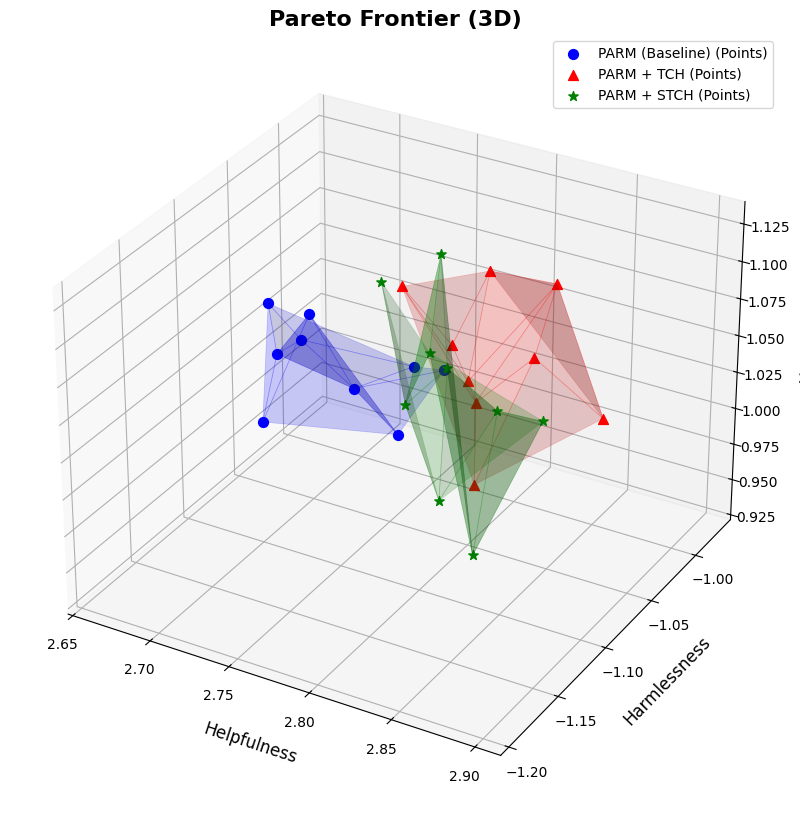

In [ ]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

BASE_DIR = "/home/sjkim/parm/code/evaluation/results/hh"
ALGORITHMS = {
    "parm": {"label": "PARM (Baseline)", "color": "blue", "marker": "o"},
    "tch": {"label": "PARM + TCH", "color": "red", "marker": "^"}, 
    "stch": {"label": "PARM + STCH", "color": "green", "marker": "*"},
}

preferences = [
    (0.1, 0.8, 0.1),
    (0.2, 0.2, 0.6),
    (0.2, 0.4, 0.4),
    (0.2, 0.6, 0.2),
    (0.33, 0.33, 0.33),
    (0.4, 0.4, 0.2),
    (0.4, 0.2, 0.4),
    (0.6, 0.2, 0.2),
    (0.8, 0.1, 0.1)
]

def load_all_metrics_3d(algo_name):
    rewards = {"help": [], "harm": [], "humor": []}
    
    for alpha_help, alpha_harm, alpha_humor in preferences:
        dir_name = f"PARM_{alpha_help}help_{alpha_harm}harm_{alpha_humor}humor"
        file_path = os.path.join(BASE_DIR, algo_name, dir_name, "mean_result.json")
        
        if os.path.exists(file_path):
            try:
                with open(file_path, 'r') as f:
                    data = json.load(f)
                    r_help = data.get("help")
                    r_harm = data.get("harm")
                    r_humor = data.get("humor")
                    
                    if all(v is not None for v in [r_help, r_harm, r_humor]):
                        rewards["help"].append(r_help)
                        rewards["harm"].append(r_harm)
                        rewards["humor"].append(r_humor)
            except Exception:
                pass
    return rewards

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('Helpfulness', fontsize=12, labelpad=10)
ax.set_ylabel('Harmlessness', fontsize=12, labelpad=10)
ax.set_zlabel('Humor', fontsize=12, labelpad=10)
ax.set_title('Pareto Frontier (3D)', fontsize=16, fontweight='bold')

for algo, style in ALGORITHMS.items():
    data = load_all_metrics_3d(algo)
    
    if not data["help"]:
        continue

    xs = np.array(data['help'])
    ys = np.array(data['harm'])
    zs = np.array(data['humor'])

    ax.scatter(xs, ys, zs, 
               label=f"{style['label']} (Points)", 
               c=style["color"], 
               marker=style["marker"], 
               s=50, depthshade=False)
    ax.legend(loc='best') 

    try:
        surf = ax.plot_trisurf(xs, ys, zs, 
                               color=style["color"], 
                               alpha=0.2,  
                               edgecolor=style["color"], 
                               linewidth=0.5,
                               antialiased=True)
        
        surf._facecolors2d = surf._facecolor3d
        surf._edgecolors2d = surf._edgecolor3d
    except Exception as e:
        print(f"Cannot plot surface for {algo}: {e}")

In [ ]:
import os
import json
import numpy as np

BASE_DIR = "/home/sjkim/parm/code/evaluation/results/hh"
ALGORITHMS = {
    "parm": {"label": "PARM (Baseline)"},
    "tch": {"label": "PARM + TCH"},
    "stch": {"label": "PARM + STCH"},
}

preferences = [
    (0.1, 0.8, 0.1),
    (0.2, 0.2, 0.6),
    (0.2, 0.4, 0.4),
    (0.2, 0.6, 0.2),
    (0.33, 0.33, 0.33),
    (0.4, 0.4, 0.2),
    (0.4, 0.2, 0.4),
    (0.6, 0.2, 0.2),
    (0.8, 0.1, 0.1)
]

def load_rewards_3d(algo_name):
    rewards_help = []
    rewards_harm = []
    rewards_humor = []

    for alpha_help, alpha_harm, alpha_humor in preferences:
        dir_name = f"PARM_{alpha_help}help_{alpha_harm}harm_{alpha_humor}humor"
        file_path = os.path.join(BASE_DIR, algo_name, dir_name, "mean_result.json")
        
        if os.path.exists(file_path):
            try:
                with open(file_path, 'r') as f:
                    data = json.load(f)
                    r_help = data.get("help")
                    r_harm_val = data.get("harm")
                    r_harm = -r_harm_val if r_harm_val is not None else None 
                    
                    r_humor = data.get("humor")
                    
                    if all(v is not None for v in [r_help, r_harm, r_humor]):
                        rewards_help.append(r_help)
                        rewards_harm.append(r_harm)
                        rewards_humor.append(r_humor)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
    
    return rewards_help, rewards_harm, rewards_humor

def calculate_2d_area(points, ref_x, ref_y):
    sorted_points = sorted(points, key=lambda p: p[0], reverse=True)
    
    area = 0.0
    current_max_y = ref_y
    
    for x, y in sorted_points:
        if y > current_max_y:
            width = max(0, x - ref_x)
            height = max(0, y - current_max_y)
            area += width * height
            current_max_y = y
    return area

def calculate_hypervolume_3d(points_3d, ref_point):

    if not points_3d:
        return 0.0

    ref_x, ref_y, ref_z = ref_point

    valid_points = [p for p in points_3d if p[0] >= ref_x and p[1] >= ref_y and p[2] >= ref_z]
    if not valid_points:
        return 0.0

    valid_points.sort(key=lambda p: p[2], reverse=True)
    
    hv = 0.0

    for i in range(len(valid_points)):

        active_points_xy = [(p[0], p[1]) for p in valid_points[:i+1]]

        z_curr = valid_points[i][2]
        z_next = valid_points[i+1][2] if i < len(valid_points) - 1 else ref_z

        height = z_curr - z_next
        
        if height > 0:
            area_xy = calculate_2d_area(active_points_xy, ref_x, ref_y)
            hv += area_xy * height
            
    return hv

def calculate_mip_3d(r_help, r_harm, r_humor):
    if not r_help or len(r_help) != len(preferences):
        return 0.0
        
    ip_list = []
    for i, (w_help, w_harm, w_humor) in enumerate(preferences):
        val_help = r_help[i]
        val_harm = r_harm[i]
        val_humor = r_humor[i]
        
        # Inner Product = w^T * r
        ip = (w_help * val_help) + (w_harm * val_harm) + (w_humor * val_humor)
        ip_list.append(ip)
        
    return np.mean(ip_list)

def main():
    all_data = {}
    
    global_min_help = float('inf')
    global_min_harm = float('inf')
    global_min_humor = float('inf')
    
    print("Loading data...")

    for algo_key in ALGORITHMS.keys():
        rh, rm, ru = load_rewards_3d(algo_key)
        if rh:
            points = list(zip(rh, rm, ru))
            all_data[algo_key] = {'points': points, 'rh': rh, 'rm': rm, 'ru': ru}
            
            # Global Min 갱신
            global_min_help = min(global_min_help, min(rh))
            global_min_harm = min(global_min_harm, min(rm))
            global_min_humor = min(global_min_humor, min(ru))
        else:
            print(f"Warning: No data for {algo_key}")

    if global_min_help == float('inf'):
        print("No valid data found.")
        return

    padding = 1.0
    ref_point = (global_min_help - padding, global_min_harm - padding, global_min_humor - padding)
    
    print(f"\n[Reference Point]: {tuple(np.round(ref_point, 4))}")
 
    header = f"{'Algorithm':<15} | {'Hypervolume':<12} | {'HV Imp(%)':<10} | {'MIP':<10} | {'MIP Imp(%)':<10}"
    print("-" * len(header))
    print(header)
    print("-" * len(header))

    baseline_hv = 0.0
    baseline_mip = 0.0
    if "parm" in all_data:
        baseline_hv = calculate_hypervolume_3d(all_data["parm"]['points'], ref_point)
        baseline_mip = calculate_mip_3d(all_data["parm"]['rh'], all_data["parm"]['rm'], all_data["parm"]['ru'])

    for algo_key, style in ALGORITHMS.items():
        if algo_key not in all_data:
            continue
            
        d = all_data[algo_key]

        hv = calculate_hypervolume_3d(d['points'], ref_point)
        mip = calculate_mip_3d(d['rh'], d['rm'], d['ru'])

        hv_imp = "-"
        mip_imp = "-"
        
        if algo_key == "parm":
            hv_imp = "(Base)"
            mip_imp = "(Base)"
        else:
            if baseline_hv != 0:
                hv_ratio = ((hv - baseline_hv) / baseline_hv) * 100
                hv_imp = f"{hv_ratio:+.2f}"
            if baseline_mip != 0:
                mip_ratio = ((mip - baseline_mip) / baseline_mip) * 100
                mip_imp = f"{mip_ratio:+.2f}"

        print(f"{style['label']:<15} | {hv:<12.4f} | {hv_imp:<10} | {mip:<10.4f} | {mip_imp:<10}")

    print("-" * len(header))

if __name__ == "__main__":
    main()

Loading data...

[Reference Point]: (1.664, -0.0249, -0.0646)
---------------------------------------------------------------------
Algorithm       | Hypervolume  | HV Imp(%)  | MIP        | MIP Imp(%)
---------------------------------------------------------------------
PARM (Baseline) | 1.3814       | (Base)     | 1.6399     | (Base)    
PARM + TCH      | 1.7401       | +25.97     | 1.6876     | +2.91     
PARM + STCH     | 1.7373       | +25.77     | 1.6911     | +3.12     
---------------------------------------------------------------------
